# ACM Imbalanced Learning - Sampling Methods

This notebook contains a selection of various sampling methods used to modify an imbalanced dataset. These include undersampling and oversampling techniques. To simplify the visualization of the sampling, a small generated dataset it used.

In [76]:
# Import useful libraries used in the notebook
import time
import numpy as np
import matplotlib.pyplot as plt

# Show plots inline 
%matplotlib inline

from sklearn.datasets import make_classification

from pylab import rcParams

# Auto-reload external modules
%load_ext autoreload
%autoreload 2

plt.subplots_adjust(bottom=.05, top=.9, left=.05, right=.95)
rcParams['figure.figsize'] = (10.0, 5.0)

def comp_scatter(x_left, y_left, title_left, x_right=None, y_right=None, title_right=None):
    '''
    Utility function to create comparison scatter plots. 
    '''
    # Plot left-hand scatterplot
    plt1 = plt.subplot(121)
    plt.title(title_left, fontsize='large')
    plt1.scatter(x_left[:, 0], x_left[:, 1], s=500, c=(1-y_left), 
                 edgecolors='black', cmap=plt.cm.bone, alpha=0.8)
    
    if (title_right == None):
        return 
    
    # Plot right hand scatterplot
    plt.subplot(122, sharex=plt1, sharey=plt1)
    plt.title(title_right, fontsize='large')
    plt.scatter(x_right[:, 0], x_right[:, 1], s=500, c=(1-y_right), 
                edgecolors='black', cmap=plt.cm.bone, alpha=0.8)    
    return 


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Generate the dataset for use in the sampling code below.

To demonstrate the sampling methods, we'll generate a small dataset using scikit-learn's ```make_classification``` function we imported earlier. This has many parameters to control the generated data, the main ones we're using here are:

* Generate 100 samples - ```n_samples = 100```
* Use imbalance of 90:10 - ```weights=[0.9, 0.1]```
* Give repeatable data - ```random_state=23```


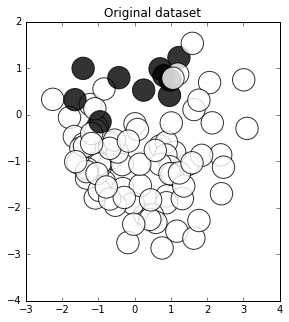

In [87]:
plt1 = plt.subplot(121)
plt.title("Original dataset", fontsize='large')
x, y = make_classification(n_samples=100, n_features=2, 
                           n_informative=2, n_redundant=0, n_repeated=0,
                           n_classes=2, n_clusters_per_class=2, weights=[0.9, 0.1],
                           random_state=23)
comp_scatter(x, y, 'Original dataset')

# Random Oversampling

In Random Oversampling, minority classes are duplicated and added to the dataset at random (with replacement). This can lead to overfitting due to the many duplicated minority cases which don't add any new information to the model. 

It's hard to make out the effect on the scatterplot, as replacement minority examples are duplicated exactly.

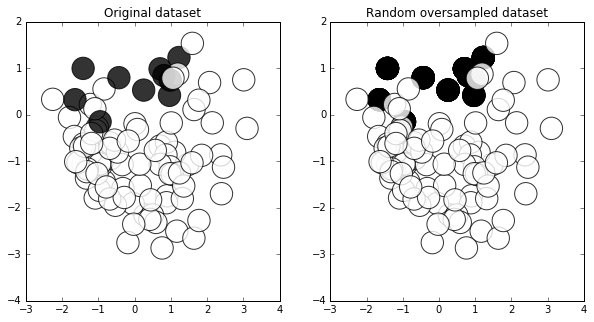

In [88]:
# Create a random sample with balanced examples
x_min = x[y == 1]
x_maj = x[y == 0]
num_min = x_min.shape[0]
num_maj = x_maj.shape[0]
x_min_oversamp = x_min

while (x_maj.shape[0] > x_min_oversamp.shape[0]):
    x_min_idx = np.random.randint(num_min, size=num_min)
    x_min_oversamp = np.vstack((x_min_oversamp, x_min[x_min_idx]))

x_oversamp = np.vstack((x_min_oversamp, x_maj))
y_oversamp = np.vstack(np.array(([1] * num_maj) + ([0] * num_maj)))

comp_scatter(x, y, 'Original dataset', 
             x_oversamp, y_oversamp, 'Random oversampled dataset')


# Random Undersampling

Random undersampling is the opposite of random oversampling. Instead of adding more minority examples, majority examples are removed to correct the balance.


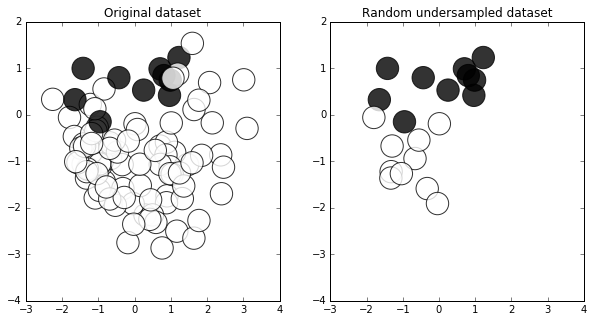

In [89]:
# Create a random sample with balanced examples
x_min = x[y == 1]
x_maj = x[y == 0]
num_min = x_min.shape[0]
num_maj = x_maj.shape[0]
x_maj_idx = np.random.randint(num_maj, size=num_min)
x_maj_undersamp = x_maj[x_maj_idx]

# Combine minority and balanced majority examples
x_undersamp = np.vstack((x_min, x_maj_undersamp))
y_undersamp = np.vstack(np.array(([1] * num_min) + ([0] * num_min)))

comp_scatter(x, y, 'Original dataset', 
             x_undersamp, y_undersamp, 'Random undersampled dataset')

# SMOTE: Synthetic Minority Over-sampling Technique

For a full description of the algorithm, see [1]. Simplified pseudocode is shown below:

```
For each minority example 'm':
    Find k-nearest neighbours, store in array
    
For each minority example 'm':
    Pick one of k nearest neighbours, call it 'a'
    Generate uniform random float between 0.0 and 1.0 = 'c'
    Create a new minority class example  by interpolating between 'm' and 'a' using 'c'
    
```
[1] Chawla et al, "SMOTE: Synthetic Minority Over-sampling Technique", Journal of Artificial Intelligence Research 16 (2002).

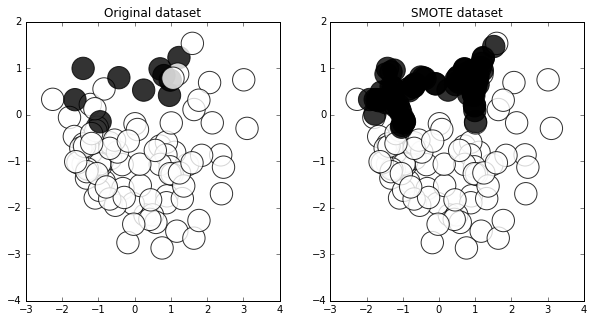

In [149]:
# Split data into minority and majority example arrays
x_min = x[y == 1]
x_maj = x[y == 0]
num_all = x.shape[0]
num_min = x_min.shape[0]
num_maj = x_maj.shape[0]

# SMOTE parameters
ratio = (num_maj / num_min) - 1 # Amount of times to replicate minority examples
k = 5 # nearest neighbours to choose from

# Generate matrix of 2-norms with # minority class rows and 
# total examples columns 
knn_dist = np.zeros((num_min, num_all))
for x_min_idx, x_min_val in enumerate(x_min):
    for x_idx, x_val in enumerate(x):
        knn_dist[x_min_idx, x_idx] = np.sqrt(np.sum(np.square(x_min_val - x_val)))
        
# Now find the k-nearest neighbours by sorting in ascending order across rows
# and taking the first [1:k+1] entries. Entry [0] will be 0 as the minority 
# example is included in its own calculation.
knn_sorted_idx = np.argsort(knn_dist, -1)
knn = knn_sorted_idx[:,1:k+1]

# Now until we have enough new examples
x_smote = np.zeros((num_min * ratio, x.shape[-1]))
for smote_run in xrange(ratio):
    for x_min_idx, x_min_val in enumerate(x_min):
        a = x[knn[x_min_idx, np.random.randint(k)]]
        c = np.random.uniform()
        new_smote = x_min_val + (c * (a - x_min_val))
#         print 'x_min_val = {}, a = {}, c = {}, new_smote = {}'.format(x_min_val, a, c, new_smote)
        x_smote[(smote_run*num_min) + x_min_idx] = new_smote

y_smote = np.ones_like(x_smote[:,0])

x_smote_out = np.vstack((x, x_smote))
y_smote_out = np.hstack((y, y_smote))

comp_scatter(x, y, 'Original dataset', 
             x_smote_out, y_smote_out, 'SMOTE dataset')


In [148]:
print x_min.shape
print x_maj.shape
print x_smote.shape
print x.shape

print y.shape
print x_smote_out.shape
# print y_smote_out.shape

print num_min
print num_maj
print ratio

print y_smote.shape
print np.hstack((y, y_smote))

(10, 2)
(90, 2)
(80, 2)
(100, 2)
(100,)
(180, 2)
10
90
8
(80,)
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  1.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  1.  1.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  1.  0.  1.  0.  0.  0.  1.  0.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.]


In [29]:
num_all

100

In [31]:
np.zeros((10,100))

array([[ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0